# Bayesian Parameter Estimation on MBL Data
## Nathan Belliveau, Griffin Chure, Manuel Razo
**July 7, 2016**

In [1]:
import numpy as np
import pandas as pd
import emcee
import scipy.special
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import seaborn as sns
import corner
rc = {'lines.linewidth': 1.5,
      'axes.labelsize' : 14,
      'axes.titlesize' : 18,
      'axes.facecolor' : 'EBEBEB',
      'axes.edgecolor' : '000000',
      'axes.linewidth' : 0.75,
      'axes.frameon' : True,
      'xtick.labelsize' : 11,
      'ytick.labelsize' : 11,
      'font.family' : 'Droid Sans',
      'grid.linestyle' : ':',
      'grid.color' : 'a6a6a6',
      'mathtext.fontset' : 'stixsans',
      'mathtext.sf' : 'sans'}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans') 
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#------------------------------------------------------------------------------- 
%matplotlib notebook

Our data consists of a set of fold-change in gene expression values from a set of experiments conducted at Woods Hole, MA at MBL Physiology. The purpose of this notebook is to perform a two-parameter fit on the active and inactive dissociation constants of the Lac repressor to IPTG. Using Bayes' rule, we can say that

$$
\begin{align}
P(\{a\} \vert D, I) &\propto P(D \vert \{a\}, I) P(\{a\} \vert I) \\
& \propto P(D \vert K_a, K_i, I) P(K_a \vert I) P(K_i \vert I)
\end{align}
$$

where $\{a\}$ is the set of dissociation constants for the active and inactive repressors ($K_a$ and $K_i$ repsectively), $D$ are our data, and $I$ is the prior information we have with regards to the system. Note that in this case we are considering that the two dissociation constants are independent parameters. This is probably not correct as it would make logical sense that the ability to bind inducer in the active vs inactive state uses a similar binding pocket and are therefore related. For now, it is not obvious how these two parameters are related mathematically, so we will treat them as completely independent. We can be more explicity with the functional form of our posterior as follows: 

$$
P(K_a, K_i \vert D, I) \propto \prod\limits_{i=1}^N \exp\left\{\frac{fc_i - fc(R, IPTG, \Delta\epsilon_r, K_a, K_i, \epsilon_{ai}))^2}{\sigma_i}\right\}\frac{1}{K_a^{max} - K_a^{min}}\cdot \frac{1}{K_i^{max} - K_i^{min}}\cdot \frac{1}{\sigma_i}
$$

where we have taken a uniform prior on the two dissociation constants. Using some of our physical intution, we known that a lower bound for the dissociation constant is that of the strongest non-covalent bond (biotin-streptavidin) and the upper bound would be Van der Waals interactions. 

## Defining the log posterior

Below, we define the functions needed to perform our parameter estimation.

In [4]:
# define a funciton to compute the fold change as a funciton of IPTG
def pact(IPTG, Ka=88.4E-3, Ki=4.71E-3, epsilon=4):
    '''
    Returns the probability of a repressor being active as described by the MWC
    model.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    Ka, Ki : float.
        Dissociation constant of the active and inactive states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    Returns
    -------
    pact : float.
        probability of a repressor of being in the active state. Active state is
        defined as the state that can bind to the DNA.
    '''
    pact = (1 + IPTG / Ka)**2 / ((1 + IPTG / Ka)**2 + np.exp(-epsilon) * (1 + IPTG / Ki)**2)
    return pact

In [47]:
def fold_change(IPTG, Ka=88.4E-3, Ki=4.71E-3, epsilon=4, R=11, epsilon_r=-13.9):
    '''
    Returns the gene expression fold change according to the thermodynamic model
    with the extension that takes into account the effect of the inducer.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    Ka, Ki : float.
        Dissociation constant of the active and inactive states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    R : array-like.
        repressor copy number for each of the strains. The length of this array
        should be equal to the IPTG array. If only one value of the repressor is
        given it is asssume that all the data points should be evaluated with
        the same repressor copy number
    epsilon_r : array-like
        repressor binding energy. The length of this array
        should be equal to the IPTG array. If only one value of the binding
        energy is given it is asssume that all the data points 
        should be evaluated with the same repressor copy number
        
    Returns
    -------
    fold-change : float.
        gene expression fold change as dictated by the thermodynamic model.
   '''
    return 1 / (1 + 2 * R / 5E6 * pact(IPTG, Ka, Ki, epsilon) * \
            (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))
 

In [39]:
def log_likelihood(param, IPTG, fc, R, ep_r, ep_ai):
    """
    Computes the log likelihood.
    """
    #Unpack the parameters.
    Ka, Ki, sigma = param
    #compute the fc.
    fc_theo = fold_change(IPTG, Ka=Ka, Ki=Ki, epsilon=ep_ai, R=R, epsilon_r=ep_r) 
   
    log_like =  np.sum((fc_theo - fc)**2) / 2 / sigma**2
    return log_like
   
def log_post(param, IPTG, fc, R, ep_r, ep_ai, Kmin, Kmax):
    Ka, Ki, sigma = param
    if (Ka > Kmax) or (Ka < Kmin):
        return -np.inf
    elif (Ki > Kmax) or (Ki < Kmin):
        return -np.inf
    elif sigma < 0:
        return -np.inf
    else:
        return -(len(IPTG) + 1) * np.log(sigma) \
        - log_likelihood(param, IPTG, fc, R, ep_r, ep_ai)

In [40]:
log_likelihood([1, 0.1, 1], rbs.IPTG, rbs.fold_change, 130, -13.9, 4.5)
log_post([1, 0.1, 9], rbs.IPTG, rbs.fold_change, 130, -13.9, 4.5, 1E-15, 1)

-105.53907207855976

In [41]:
#Load the data. 
data = pd.read_csv('../../data/mbl_2016/MBL_fc_data.csv')
rbs = data[(data.strain=='1027') & (data.epsilon_r==-13.9)]

#Define the packed values for simplicity
Kmin = 1E-15
Kmax = 1

#Define the parameters for emcee
n_dim = 3 
n_walkers = 50
n_burn = 300
n_steps = 500 
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(Kmin, Kmax, n_walkers)
p0[:,1] = np.random.uniform(Kmin, Kmax, n_walkers)
p0[:,2] = np.random.uniform(1E-6, 1, n_walkers)

In [42]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(rbs.IPTG, rbs.fold_change, 130, -13.9, 4.5, Kmin, Kmax),\
                threads=6)

In [60]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [61]:
_ = sampler.run_mcmc(pos, n_steps)

<IPython.core.display.Javascript object>


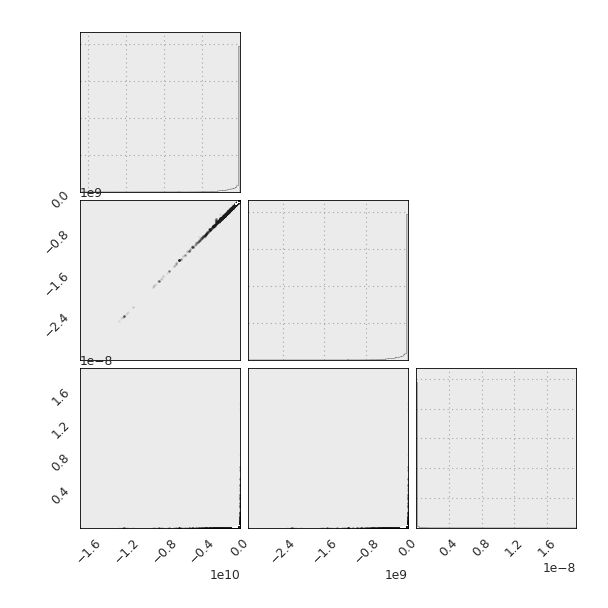

In [62]:
fig = corner.corner(sampler.flatchain, bins=100, plot_contours=False)

# Trying to sample $K_A$ and $K_I$ in log space 

In [63]:
# define a funciton to compute the fold change as a funciton of IPTG
def pact_log(IPTG, ea, ei, epsilon):
    '''
    Returns the probability of a repressor being active as described by the MWC
    model.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    epsilon : float.
        energy difference between the active and the inactive state
    Returns
    -------
    pact : float.
        probability of a repressor of being in the active state. Active state is
        defined as the state that can bind to the DNA.
    '''
    pact = (1 + IPTG * np.exp(-ea))**2 / \
    ((1 + IPTG * np.exp(-ea))**2 + np.exp(-epsilon) * (1 + IPTG * np.exp(-ei))**2)
    return pact



In [88]:
def fold_change_log(IPTG, ea, ei, epsilon, R, epsilon_r):
    '''
    Returns the gene expression fold change according to the thermodynamic model
    with the extension that takes into account the effect of the inducer.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    epsilon : float.
        energy difference between the active and the inactive state
    R : array-like.
        repressor copy number for each of the strains. The length of this array
        should be equal to the IPTG array. If only one value of the repressor is
        given it is asssume that all the data points should be evaluated with
        the same repressor copy number
    epsilon_r : array-like
        repressor binding energy. The length of this array
        should be equal to the IPTG array. If only one value of the binding
        energy is given it is asssume that all the data points 
        should be evaluated with the same repressor copy number
        
    Returns
    -------
    fold-change : float.
        gene expression fold change as dictated by the thermodynamic model.
   '''
    return 1 / (1 + 2 * R / 5E6 * pact_log(IPTG, ea, ei, epsilon) * \
            (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))

In [93]:
def log_likelihood_log(param, IPTG, fc, R, ep_r, ep_ai):
    """
    Computes the log likelihood.
    """
    #Unpack the parameters.
    ea, ei, sigma = param
    #compute the fc.
    fc_theo = fold_change_log(IPTG,
                        ea=ea, ei=ei, epsilon=ep_ai, R=R, epsilon_r=ep_r) 
   
    log_like =  np.sum((fc_theo - fc)**2) / 2 / sigma**2
    return log_like
   
def log_post_log(param, IPTG, fc, R, ep_r, ep_ai):
    ea, ei, sigma = param
    if ea > 0 or ea < -20 \
    or ei > 0 or ei < -20 \
    or sigma < 0:
        return -np.inf
    return -(len(IPTG) + 1) * np.log(sigma) \
    - log_likelihood_log(param, IPTG, fc, R, ep_r, ep_ai)

In [123]:
#Define the parameters for emcee
n_dim = 3 
n_walkers = 1000
n_burn = 5000
n_steps = 5000 
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(-4, 0, n_walkers)
p0[:,1] = np.random.uniform(-8, -4, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

In [124]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post_log,\
                args=(rbs.IPTG.values, rbs.fold_change.values, 130, -13.9, 4.5),\
                threads=6)

In [125]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [126]:
_ = sampler.run_mcmc(pos, n_steps)

<IPython.core.display.Javascript object>


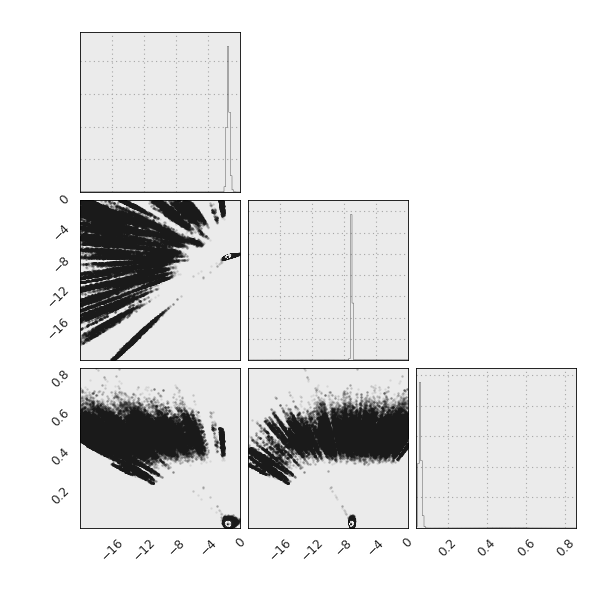

In [127]:
fig = corner.corner(sampler.flatchain, bins=100, plot_contours=False)

In [87]:
np.mean(sampler.flatchain[:, 2])

2.0339418709442817e-12